In [1]:
import sys
sys.path.insert(0, '../')


import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm
from tqdm import tqdm_notebook


from params import SEED, N_SPLITS
%matplotlib inline

In [2]:
tqdm_notebook().pandas()

In [3]:
test_raw = pd.read_csv('../data/test.csv')
dev_raw = pd.read_csv('../data/train.csv')
categories = pd.read_csv('../data/category.csv')

In [4]:
dev_raw.head()

,item_id,title,description,price,category_id
0,0,Картина,Гобелен. Размеры 139х84см.,1000.0,19
1,1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22
2,2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37
3,3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43
4,4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1


In [5]:
test_raw.head()

,item_id,title,description,price
0,489517,Стоик журнальный сталь,продам журнальный столик изготавливаю столы из...,10000.0
1,489518,iPhone 5 64Gb,"Телефон в хорошем состоянии. Комплект, гаранти...",12500.0
2,489519,Утеплитель,ТЕПЛОПЕЛЕН-ЛИДЕР ТЕПЛА!!! Толщина утеплителя :...,250.0
3,489520,Пальто демисезонное,Продам пальто женское (букле) в отличном состо...,1700.0
4,489521,Samsung syncmaster T200N,"Условно рабочий, проблема в панели настройки м...",1000.0


In [6]:
n_categories = len(dev_raw['category_id'].unique())
print('Число разных категорий: ', n_categories)

Число разных категорий:  54


Посмотрим на распередление объявлений по разным категориям  и убедимся что классы достаточно сбалансированы.

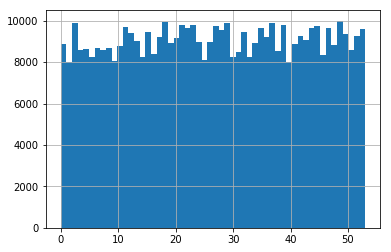

In [7]:
dev_raw['category_id'].hist(bins=n_categories)

In [8]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[^\W_]+')

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")


from pymystem3 import Mystem
stemmer = Mystem()

[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# приведем слова к нормальной форме используя , чтобы уменьшить размер итогового словаря
def lemmatize(text):
    return stemmer.lemmatize(text)[:-1]

# уберем длинные(полупроизвольно выбрал значение в 4 символа, поскольку 3 могут встречаться 
# в валидных аббревиатурах, например, СССР)
# повторения буквенных(цифры оставим) символов

import re
expr = re.compile(r'([^\W_0-9])\1{4,}')
def remove_long_seqs(text):
    return re.sub(expr, r'\1', text)

def clean_up(text):
    return [token for token in text if  token not in russian_stopwords and len(token) > 1]



def prepare_data(df):
    df = df.copy()
    # объеденим название и описание в один текст
    df['text'] = df['title'].str.cat(df['description'], ' ')
    df['text'] = df['text'].progress_apply(remove_long_seqs)
    # разобьем текст на токены, оставляя только буквы и цифры
    print('tokenizing...')
    df['tokens'] = df['text'].str.lower().progress_apply(lambda text: tokenizer.tokenize(text)).str.join(' ')
    # лемматизируем полученную последовательность токенов
    print('lemmatizing...')
    df['tokens'] = df['tokens'].progress_apply(lemmatize).str.join('')
    print('cleaning up...')
    df['tokens'] = df['tokens'].str.split(' ').progress_apply(clean_up)
    return df.drop(['title', 'description', 'text'], axis=1)

У меня была гипотеза о том, что упоминание в тексте объявления слов может быть полезной фичей. Поэтому для каждой категории я создаю новую фичу, равную метрике Жакарда между текстом объявления и названием категории(после удаления стоп слов). Такое преобразование не использует информации об остальных примерах, поэтому мы можем применить его сразу для всех датасетов, не волнуясь об утечке.

In [38]:

cat_words = categories.name.str.replace('|',' ').str.lower().progress_apply(lemmatize).str.join('').str.split()
cat_words = cat_words.apply(set).apply(lambda x: x.difference(russian_stopwords))

def jaccard(x):
    return [len(cat_words[i].intersection(x))/len(cat_words[i].union(x)) for i in cat_words.index]


def compute_jaccard(data):

    words = data['tokens'].apply(lambda x: set(x).difference(russian_stopwords))

    j = words.apply(jaccard)
    df = pd.DataFrame(j.values.tolist(), columns=[f'cat_{i}' for i in cat_words.index])
    return  df



# я планировал использовать fastText, поэтому сразу определил функции позволяющие сохранять данные в формате
# удобном для работы с ним
def write_ft_train(path, data, label):
    with  open(path, 'w') as f:
            for idx, cat, lst, in data[[ 'category_id', 'tokens']].itertuples():
                text = ' '.join(lst)
                f.write(f'__label__{cat} {text}\n')

def write_ft_test(path, data, label=None):
    
    data['tokens'].str.join(' ').to_csv(path, index=False)
    if label is not None:
        data[label].to_csv(path + '.label')

In [21]:
dev = prepare_data(dev_raw)
test = prepare_data(test_raw)


tokenizing...



lemmatizing...



cleaning up...



tokenizing...



lemmatizing...



cleaning up...


In [25]:
dev = pd.concat([dev, compute_jaccard(dev)], axis=1)
test = pd.concat([test, compute_jaccard(test)], axis=1)

It would be more convinient to use torchtext if we put data of same type in list field rather than bunch of separate fields

In [26]:
dev['jacs'] = dev[[x for x in dev.columns if 'cat_' in x]].values.tolist()
test['jacs'] = test[[x for x in dev.columns if 'cat_' in x]].values.tolist()

Let's split development dataset into training and validation dataset in the ratio 1:4

In [27]:
train, valid = train_test_split(dev, test_size = 0.2, random_state=SEED, stratify=dev['category_id'])

JSON format is acceptable by pandas and more effective with torchtext.

In [28]:
dev.to_json('../data/json/dev.json', orient='records', lines=True)
train.to_json('../data/json/train.json', orient='records', lines=True)
valid.to_json('../data/json/valid.json', orient='records', lines=True)
test.to_json('../data/json/test.json', orient='records', lines=True)

Also we need to write 5-fold splits to disk to use them with pytorch and fastext

In [40]:
skf = StratifiedKFold(n_splits=N_SPLITS, random_state=SEED)
for fold, (train_idx, test_idx) in enumerate(skf.split(train, train['category_id'])):
    train_fold = train.iloc[train_idx]
    test_fold = train.iloc[test_idx]
    
    train_fold.to_json(f'../data/json/kfolds/train_{fold}.json', orient='records', lines=True)
    test_fold.to_json(f'../data/json/kfolds/test_{fold}.json', orient='records', lines=True)
    

    write_ft_train(f'../data/ft/kfolds/train_{fold}.txt', train_fold, label='category_id')
    write_ft_test(f'../data/ft/kfolds/test_{fold}.txt', test_fold, label='category_id')

In [41]:
write_ft_train(f'../data/ft/train.txt', dev, label='category_id')
write_ft_test(f'../data/ft/test.txt', test)

write_ft_train(f'../data/ft/train.txt', train, label='category_id')
write_ft_test(f'../data/ft/train.txt', valid,  label='category_id')

In [48]:
dev.tokens.str.join(' ').to_csv('../data/full.txt',index=False, header=False)

In [49]:
with open('../data/full.txt', 'a') as f:
    test.tokens.str.join(' ').to_csv(f, index=False, header=False)

In [50]:
dev.shape[0] + test.shape[0]

732683